# Assignment 3 - Part II
**Course:** CSI 5139 - Convolutional Neural Networks in Computer Vision <br>
**Instructor:** Dr. Jochen Lang <br>
**Done By:** Selameab Demilew <br>
**Student ID:** 6591627 <br>
**Date:** Nov. 26, 2018 <br>

# Init

In [0]:
# Download dataset
# !wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

In [0]:
# Extract
# !tar xvzf CUB_200_2011.tgz > /dev/null

In [3]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import set_random_seed
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from PIL import Image
import cv2 # Used only for drawing bounding boxes and dots

Using TensorFlow backend.


In [0]:
# Fix seeds for reproducibility
np.random.seed(1921)
set_random_seed(1921)

In [0]:
# CONSTANTS

IMG_SIZE = 224

CLASSES = ['Cardinal', 
           'American_Goldfinch',
           'Evening_Grosbeak',
           'Song_Sparrow',
           'Tree_Sparrow',
           'House_Sparrow',
           'Fox_Sparrow',
           'Canada_Warbler',
           'Myrtle_Warbler',
           'House_Wren',
           'Red_winged_Blackbird',
           'Boat_tailed_Grackle']

PARTS = ['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right eye', 'right leg', 'right wing', 'tail', 'throat']

IMAGES_TXT = 'CUB_200_2011/images.txt'
BB_TXT = 'CUB_200_2011/bounding_boxes.txt'
PART_LOCS_TXT = 'CUB_200_2011/parts/part_locs.txt'
TRAIN_TEST_SPLIT_TXT = 'CUB_200_2011/train_test_split.txt'
IMAGES_DIR = 'CUB_200_2011/images'

# Dataset

In [0]:
# Parse necessary text files

# Parse images.txt
id2img = {}
with open(IMAGES_TXT,'r') as f:
    for line in f:
        s = line.split()
        id2img[int(s[0])] = s[1]
        
# Parse bounding boxes
id2bb = {}
with open(BB_TXT,'r') as f:
    for line in f:
        s = line.split()
        id2bb[int(s[0])] = [float(i) for i in s[1:]]
        
# Parse part locations
id2part_locs = {}
id2part_visible = {}
with open(PART_LOCS_TXT,'r') as f:
    for line in f:
        s = line.split()
        if not int(s[0]) in id2part_visible: # Create key in dict for first image
            id2part_visible[int(s[0])] = []
        id2part_visible[int(s[0])] += [int(s[4])]
        
        if not int(s[0]) in id2part_locs: # Create key in dict for first image
            id2part_locs[int(s[0])] = []
        id2part_locs[int(s[0])] += [(float(s[2]), float(s[3]))]
        
# Parse train/test split
train_list, test_list = [], []
with open(TRAIN_TEST_SPLIT_TXT,'r') as f:
    for line in f:
        s = line.split()
        if s[1] == '0':
            test_list += [int(s[0])]
        else:
            train_list += [int(s[0])]

In [0]:
# Translates coordinates b/n 0 and 1
def normalize_part_locs(part_locs, img_shape):
    normalized = []
    for p in part_locs:
        normalized += [[p[0] / img_shape[0], p[1] / img_shape[1]]]
    return normalized

def normalize_bb(bb, img_shape):
    return [bb[0] / img_shape[0], bb[1] / img_shape[1], bb[2] / img_shape[0], bb[3] / img_shape[1]]

In [0]:
# Build dataset
x_orig_train, y_train = [], {'cls':[], 'bb':[], 'part_visible':[], 'part_locs':[]}
x_orig_test, y_test = [], {'cls':[], 'bb':[], 'part_visible':[], 'part_locs':[]}
for i,img_path in id2img.items():
    # Check if image is in CLASSES
    cls = img_path[4:img_path.find('/')] 
    if not cls in CLASSES:
        continue
    
    # Read image
    x = Image.open(os.path.join(IMAGES_DIR, img_path))
    
    if i in train_list:
        x_orig_train += [np.array(x.resize((IMG_SIZE, IMG_SIZE)))]
        y_train['cls'] += [CLASSES.index(cls)]
        y_train['bb'] += [normalize_bb(id2bb[i], x.size)]
        y_train['part_visible'] += [id2part_visible[i]]
        y_train['part_locs'] += [normalize_part_locs(id2part_locs[i], x.size)]
    else:
        x_orig_test += [np.array(x.resize((IMG_SIZE, IMG_SIZE)))]
        y_test['cls'] += [CLASSES.index(cls)]
        y_test['bb'] += [normalize_bb(id2bb[i], x.size)]
        y_test['part_visible'] += [id2part_visible[i]]
        y_test['part_locs'] += [normalize_part_locs(id2part_locs[i], x.size)]

x_orig_train, x_orig_test = np.array(x_orig_train), np.array(x_orig_test)
y_train['cls'], y_test['cls'] = np.eye(len(CLASSES))[np.array(y_train['cls'])], np.eye(len(CLASSES))[np.array(y_test['cls'])]
y_train['bb'], y_test['bb'] = np.array(y_train['bb']), np.array(y_test['bb'])
y_train['part_visible'], y_test['part_visible'] = np.array(y_train['part_visible']), np.array(y_test['part_visible'])
y_train['part_locs'], y_test['part_locs'] = np.array(y_train['part_locs']), np.array(y_test['part_locs'])

**Visualize :**

*   Images are randomly selected from the dataset. 
*   The green box marks the location of the bird in the image.
*   Parts are shown as red points.



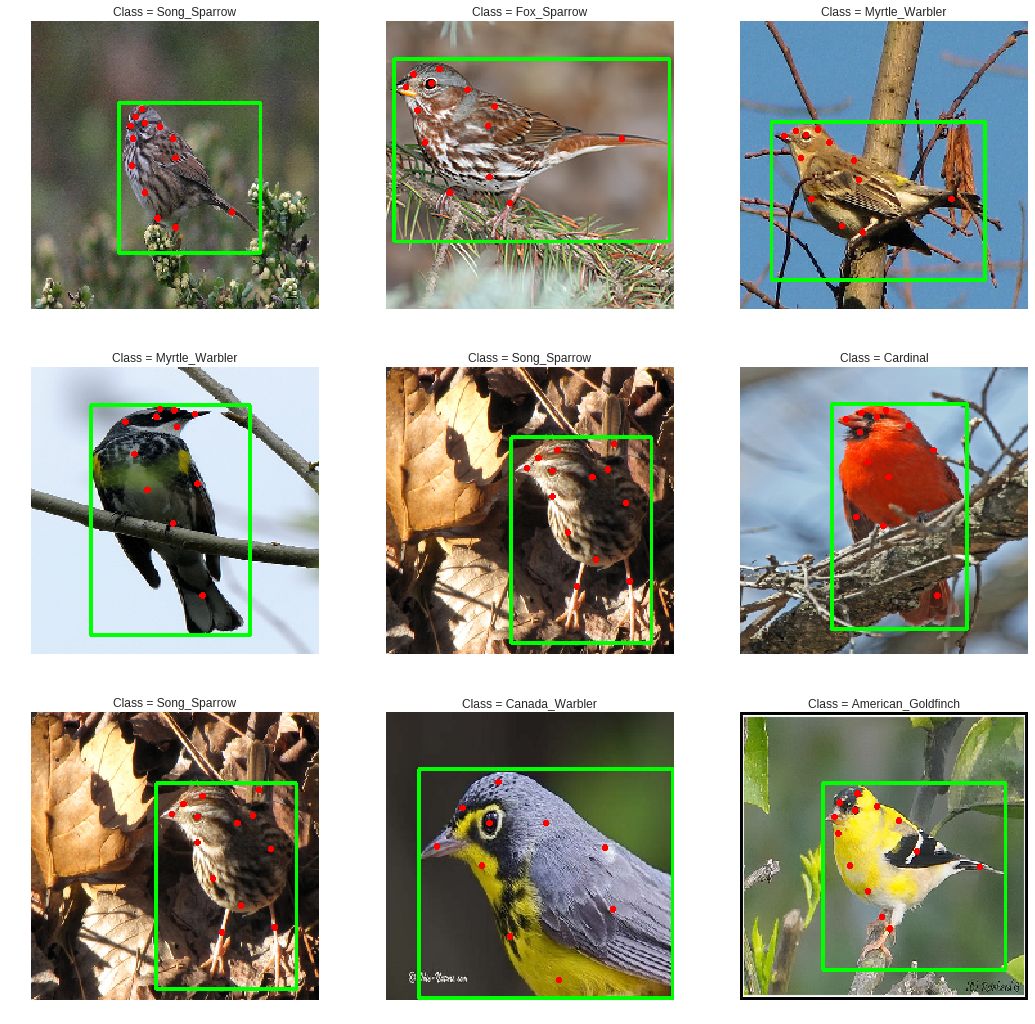

In [9]:
# Visualize
plt.gcf().set_size_inches(18, 18)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    r = np.random.randint(0, x_orig_train.shape[0])    
    temp = np.array(x_orig_train[r])
    x, y, w, h = (y_train['bb'][r] * 224).astype(int)
    cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for pt in y_train['part_locs'][r]:
        x,y = (pt * 224).astype(int)
        if x > 0 and y > 0:
            cv2.circle(temp, (x, y), 1, (255, 0, 0), 2)

    plt.title('Class = %s' % CLASSES[np.argmax(y_train['cls'][r])])
    plt.grid('off')
    plt.axis('off')
    plt.imshow(temp)

In [0]:
# Preprocess images for MobileNet V2
x_train = preprocess_input(x_orig_train.astype('float'))
x_test = preprocess_input(x_orig_test.astype('float'))

# MobileNet V2

In [0]:
# Helper function that trains the model n times and reports the average validation accuracy
def evaluate(model_factory, n=15):
    val_acc, val_loss = [], []
    for _ in range(n):
        print("*", end='')
        model = model_factory()
        model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
        model.fit(x=x_train, y=y_train['cls'], validation_data=(x_test, y_test['cls']), epochs=15, verbose=0)
        val_acc += [np.max(model.history.history['val_acc'])]
        val_loss += [np.min(model.history.history['val_loss'])]
    print('')
    return np.mean(val_acc), np.mean(val_loss) 

## Baseline Model
A baseline model is used as a reference to measure the effect of regularization.

In [0]:
def baseline():
    clear_session()
    # Load MN2
    mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze layers
    for layer in mn2_model.layers:
        layer.trainable = False
        
    # Add layers
    x = mn2_model.get_layer('block_16_project_BN').output
    x = Conv2D(160, (3, 3), activation = 'relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='tanh')(x)
    x = Dense(len(CLASSES), activation='softmax')(x)

    return Model(inputs=mn2_model.input, outputs=x)

In [13]:
baseline_acc, baseline_loss = evaluate(baseline, n=15)
print("The baseline model has an accuracy of %.2f%% and a loss of %.4f on the test set" % (baseline_acc*100.0, baseline_loss))

*Downloading data from https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
9412608/9406464 [==============================] - 0s 0us/step
**************
The baseline model has an accuracy of 61.76% and a loss of 1.1163 on the test set


## Regularization
Dropout, batch normalization and l1-regularization are evaluated. Each model is run 15 times and the resulting average accuracy is reported.

### Dropout

In [0]:
def model_with_dropout():
    clear_session()
    # Load MN2
    mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze layers
    for layer in mn2_model.layers:
        layer.trainable = False
        
    # Add layers
    x = mn2_model.get_layer('block_16_project_BN').output
    x = Conv2D(160, (3, 3), activation = 'relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = Flatten()(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(256, activation='tanh')(x)
    x = Dense(len(CLASSES), activation='softmax')(x)
    
    return Model(inputs=mn2_model.input, outputs=x)

In [15]:
dropout_acc, dropout_loss = evaluate(model_with_dropout, n=15)
print("The model with dropout has an accuracy of %.2f%% and a loss of %.4f " % (dropout_acc*100.0, dropout_loss))

***************
The model with dropout has an accuracy of 63.12% and a loss of 1.0989 


### Batch Normalization

In [0]:
def model_with_batchnorm():
    clear_session()
    # Load MN2
    mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze layers
    for layer in mn2_model.layers:
        layer.trainable = False
        
    # Add layers
    x = mn2_model.get_layer('block_16_project_BN').output
    x = Conv2D(160, (3, 3), activation = 'relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='tanh')(x)
    x = Dense(len(CLASSES), activation='softmax')(x)
    
    return Model(inputs=mn2_model.input, outputs=x)

In [17]:
batchnorm_acc, batchnorm_loss = evaluate(model_with_batchnorm, n=15)
print("The model with batch normalization has an accuracy of %.2f%% and a loss of %.4f" % (batchnorm_acc*100.0, batchnorm_loss))

***************
The model with batch normalization has an accuracy of 58.32% and a loss of 1.2345


### L1 Regularization

In [0]:
def model_with_L1():
    clear_session()
    # Load MN2
    mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze layers
    for layer in mn2_model.layers:
        layer.trainable = False
        
    # Add layers
    x = mn2_model.get_layer('block_16_project_BN').output
    x = Conv2D(160, (3, 3), activation = 'relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, kernel_regularizer=regularizers.l1(0.01), activation='tanh')(x)
    x = Dense(len(CLASSES), kernel_regularizer=regularizers.l1(0.01), activation='softmax')(x)
    
    return Model(inputs=mn2_model.input, outputs=x)

In [19]:
L1_acc, L1_loss = evaluate(model_with_L1, n=15)
print("The model with L1 regularization has an accuracy of %.2f%% and a loss of %.4f" % (L1_acc*100.0, L1_loss))

***************
The model with L1 regularization has an accuracy of 61.89% and a loss of 59.0247


The fact that the weights directly contribute to the loss function in L1-regularization has made the loss much higher. Thus, accuracy on the test set is used as a comparison metrics.


**Result:** The model implementing **Dropout** has the highest accuracy.

## Optimizers
The best model from the previous section is trained 5 times using SGD, Adam and RMSProp. All optimizers are run using their default values and no hyperparameter tuning is done.

In [0]:
def evaluate_optimizer(optimizer, n=10):
    train_hist, val_hist = [], []
    for _ in range(n):
        print('*', end='')
        clear_session()
        model = model_with_dropout()
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        model.fit(x=x_train, y=y_train['cls'], validation_data=(x_test, y_test['cls']), epochs=20, verbose=0)
        train_hist += [model.history.history['loss']]
        val_hist += [model.history.history['val_loss']]
    train_hist, val_hist = np.array(train_hist), np.array(val_hist)
    return train_hist, val_hist

In [21]:
# Evalute optimizers
n=5
sgd_hist = evaluate_optimizer('SGD', n=n)
adam_hist = evaluate_optimizer('adam', n=n)
rms_hist = evaluate_optimizer('RMSprop', n=n)

***************

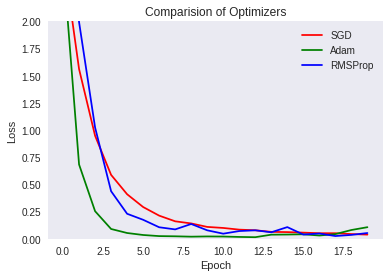

In [22]:
# Plot

plt.plot(np.mean(sgd_hist[0], axis=0), 'r')
plt.plot(np.mean(adam_hist[0], axis=0), 'g')
plt.plot(np.mean(rms_hist[0], axis=0), 'b')

plt.title('Comparision of Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('off')
plt.ylim(0, 2)
plt.legend(['SGD', 'Adam', 'RMSProp'], loc='upper right')
plt.show()

**Observation:** We can observe that Adam converges faster than the other two.

## Multi-task Learning
Two convolutional layers are added at the end of the mobilenet model. These serve as the shared layers. Then, a stack of dense layers are added for each task.

In [0]:
# Load MobileNet V2

clear_session()

# Load MN2
mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze layers
for layer in mn2_model.layers:
    layer.trainable = False

In [0]:
# Shared Layers
x = mn2_model.get_layer('block_16_project_BN').output
x = Conv2D(160, (5, 5), activation = 'relu', padding='same')(x)
x = Conv2D(64, (5, 5), activation = 'relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(rate=0.2)(x)

# Layers for Class
c = Dense(256, activation='tanh')(x)
c = Dense(len(CLASSES), activation='softmax', name='Class')(c)

# Layers for Bounding Box
b = Dense(512, activation='tanh')(x)
b = Dense(256, activation='tanh')(b)
b = Dense(4, name='Bounding_Box')(b)

model = Model(inputs=mn2_model.input, outputs=[c, b])

In [0]:
model.compile(loss={'Class':'categorical_crossentropy', 'Bounding_Box':'mse'}, 
              loss_weights= {'Class':1.0, 'Bounding_Box':0.1},
              optimizer='adam', metrics=[])

In [26]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
model.fit(x=x_train, y={'Class':y_train['cls'], 'Bounding_Box':y_train['bb']}, 
          validation_data=(x_test, [y_test['cls'], y_test['bb']]), epochs=100, callbacks=callbacks)

Train on 359 samples, validate on 357 samples
Epoch 1/100
359/359 [==============================] - 5s 13ms/step - loss: 2.8036 - Class_loss: 2.5774 - Bounding_Box_loss: 2.2620 - val_loss: 1.6349 - val_Class_loss: 1.6235 - val_Bounding_Box_loss: 0.1134
Epoch 2/100
359/359 [==============================] - 2s 6ms/step - loss: 0.8424 - Class_loss: 0.8350 - Bounding_Box_loss: 0.0741 - val_loss: 1.4185 - val_Class_loss: 1.4154 - val_Bounding_Box_loss: 0.0305
Epoch 3/100
359/359 [==============================] - 2s 6ms/step - loss: 0.4662 - Class_loss: 0.4626 - Bounding_Box_loss: 0.0358 - val_loss: 1.1500 - val_Class_loss: 1.1469 - val_Bounding_Box_loss: 0.0309
Epoch 4/100
359/359 [==============================] - 2s 6ms/step - loss: 0.2902 - Class_loss: 0.2871 - Bounding_Box_loss: 0.0311 - val_loss: 1.2928 - val_Class_loss: 1.2900 - val_Bounding_Box_loss: 0.0274
Epoch 5/100
359/359 [==============================] - 2s 6ms/step - loss: 0.1976 - Class_loss: 0.1947 - Bounding_Box_loss: 0

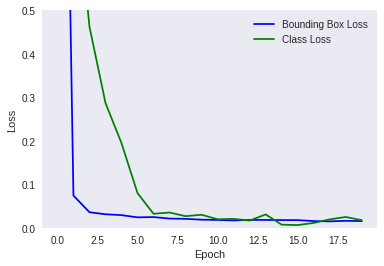

In [27]:
# Plot losses

# model.history.history.keys()
plt.plot(model.history.history['Bounding_Box_loss'], 'b')
plt.plot(model.history.history['Class_loss'], 'g')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('off')
plt.ylim(0, 0.5)
plt.legend(['Bounding Box Loss', 'Class Loss'], loc='upper right')
plt.show()

In [0]:
# Make predictions
pred_cls, pred_bb = model.predict(x_test)
pred_cls = np.argmax(pred_cls, axis=1)

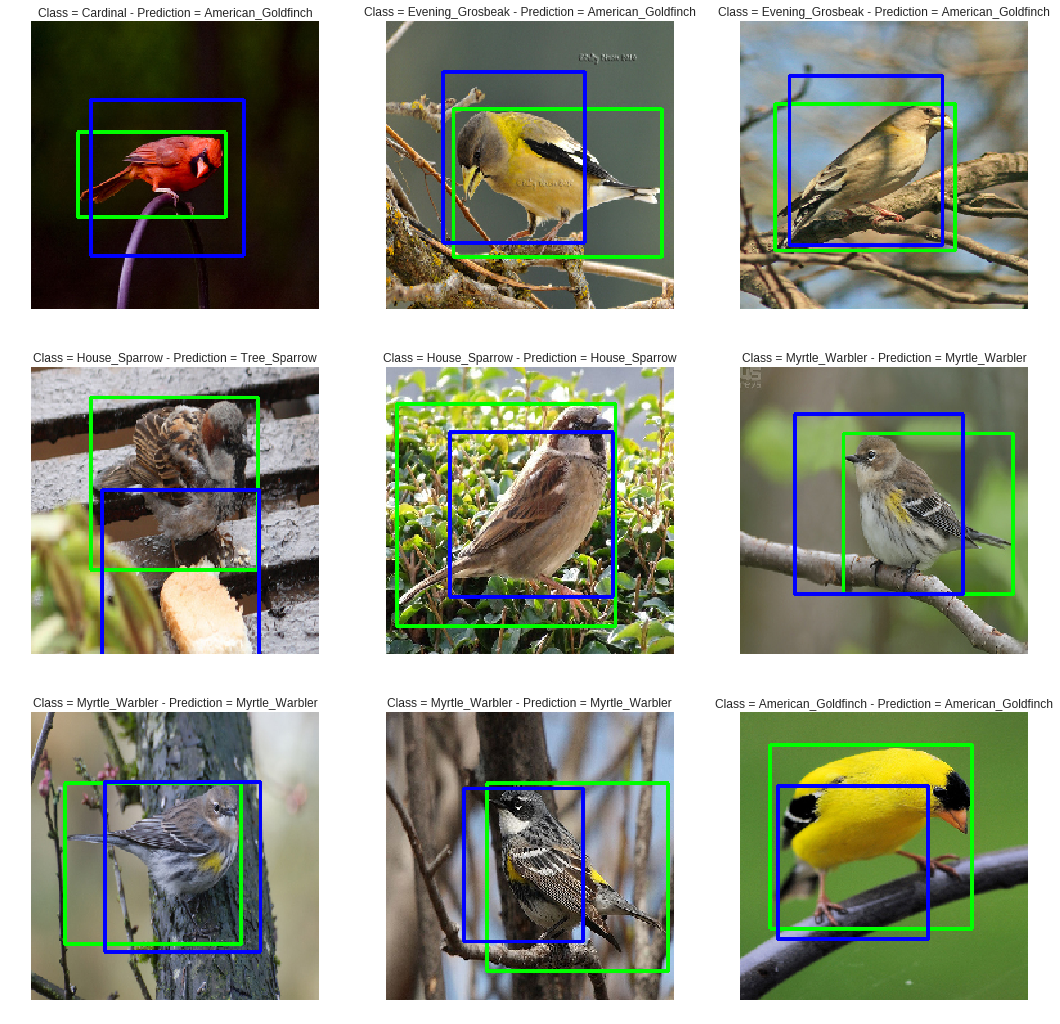

In [29]:
# Visualize Predictions
plt.gcf().set_size_inches(18, 18)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    
    r = np.random.randint(0, pred_cls.shape[0])
    
    temp = np.array(x_orig_test[r])
    
    # Original Bounding Box
    x, y, w, h = (y_test['bb'][r] * 224).astype(int)
    cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Predicted Bounding Box
    x, y, w, h = (pred_bb[r] * 224).astype(int)
    cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    
    plt.title('Class = %s - Prediction = %s' % (CLASSES[np.argmax(y_test['cls'][r])], CLASSES[pred_cls[r]]))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(temp)

*  True bounding box - Green
*  Predicted bounding box - Blue


**Observation:** Bounding box detection is not a trivial task. The model performs relatively well for such a small dataset because it uses transfer learning and multi-task learning. From visual inspection, we can see that model predicts bounding boxes around the middle. Thus, we can say that the model has "learned" that an object of interest, in this case a bird, is usually located at the center of the image.

## Additional Annotations - Bonus

This model is a multilabel classifier that predicts the presence of the 15 body parts. It builds upon the previous architecture.

In [0]:
# Load MobileNet V2

clear_session()

# Load MN2
mn2_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze layers
for layer in mn2_model.layers:
    layer.trainable = False

In [0]:
# Shared Layers
x = mn2_model.get_layer('block_16_project_BN').output
x = Conv2D(160, (5, 5), activation = 'relu', padding='same')(x)
# x = Dropout(rate=0.1)(x)
x = Conv2D(64, (5, 5), activation = 'relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(rate=0.2)(x)

# Layers for Class
c = Dense(256, activation='tanh')(x)
c = Dense(len(CLASSES), activation='softmax', name='Class')(c)

# Layers for Bounding Box
b = Dense(512, activation='tanh')(x)
b = Dense(256, activation='tanh')(b)
b = Dense(4, name='Bounding_Box')(b)

# Layers for the body parts
p = Dense(512, activation='tanh')(x)
p = Dense(256, activation='tanh')(p)
p = Dense(15, activation='sigmoid', name='Parts')(p)

model = Model(inputs=mn2_model.input, outputs=[c, b, p])

In [0]:
model.compile(loss={'Class':'categorical_crossentropy', 'Bounding_Box':'mse', 'Parts':'binary_crossentropy'}, 
              loss_weights= {'Class':1.0, 'Bounding_Box':0.1, 'Parts':10.0},
              optimizer='adam', metrics=[])

In [33]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)]
model.fit(x=x_train, y={'Class':y_train['cls'], 'Bounding_Box':y_train['bb'], 'Parts':y_train['part_visible']}, 
          validation_data=(x_test, [y_test['cls'], y_test['bb'], y_test['part_visible']]), epochs=100, callbacks=callbacks)

Train on 359 samples, validate on 357 samples
Epoch 1/100
359/359 [==============================] - 5s 14ms/step - loss: 6.2817 - Class_loss: 2.3081 - Bounding_Box_loss: 1.9876 - Parts_loss: 0.3775 - val_loss: 5.2319 - val_Class_loss: 1.9407 - val_Bounding_Box_loss: 0.0977 - val_Parts_loss: 0.3281
Epoch 2/100
359/359 [==============================] - 2s 6ms/step - loss: 3.9156 - Class_loss: 0.9315 - Bounding_Box_loss: 0.0808 - Parts_loss: 0.2976 - val_loss: 4.7119 - val_Class_loss: 1.6469 - val_Bounding_Box_loss: 0.0304 - val_Parts_loss: 0.3062
Epoch 3/100
359/359 [==============================] - 2s 6ms/step - loss: 2.9756 - Class_loss: 0.5560 - Bounding_Box_loss: 0.0445 - Parts_loss: 0.2415 - val_loss: 3.8901 - val_Class_loss: 1.2559 - val_Bounding_Box_loss: 0.0330 - val_Parts_loss: 0.2631
Epoch 4/100
359/359 [==============================] - 2s 6ms/step - loss: 2.0922 - Class_loss: 0.2538 - Bounding_Box_loss: 0.0342 - Parts_loss: 0.1835 - val_loss: 3.8781 - val_Class_loss: 1.157

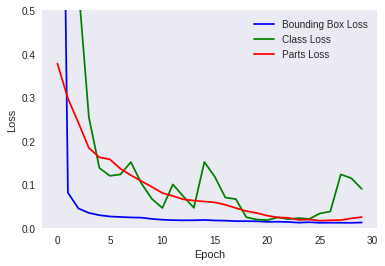

In [34]:
# Plot losses

# model.history.history.keys()
plt.plot(model.history.history['Bounding_Box_loss'], 'b')
plt.plot(model.history.history['Class_loss'], 'g')
plt.plot(model.history.history['Parts_loss'], 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('off')
plt.ylim(0, 0.5)
plt.legend(['Bounding Box Loss', 'Class Loss', 'Parts Loss'], loc='upper right')
plt.show()

In [0]:
# Make predictions
_, _, pred_parts = model.predict(x_test)
# Binarize pred (If probability > 0.5, predict 1. Else 0)
pred_parts = (pred_parts>0.5).astype(int)

In [36]:
# Evaluate accuracy on each part
print('F1 Scores:')
for i in range(15):
    f1 = f1_score(y_true=y_test['part_visible'][:, i], y_pred=pred_parts[:, i])   
    print('{:20s} {:0.3f}'.format(PARTS[i], f1))

F1 Scores:
back                 0.903
beak                 0.997
belly                0.979
breast               0.986
crown                0.997
forehead             0.992
left eye             0.837
left leg             0.944
left wing            0.873
nape                 0.976
right eye            0.808
right leg            0.924
right wing           0.812
tail                 0.977
throat               0.999


**Observation:** The F1-scores above indicate that the model has learned to predict the presence of body parts in an image.